In [2]:
import os
import numpy as np
import glob
from collections import defaultdict
import xarray as xr
import matplotlib.pyplot as plt

# Data Import and Concatenation

In [ ]:
dir_path = "/glade/work/stevenxu/AMOC_models/msftmz/scenarios/ssp370"
all_files = glob.glob(os.path.join(dir_path, "*.nc"))

In [4]:
groups = defaultdict(list)
for fp in all_files:
    fname = os.path.basename(fp)
    model_name = fname.split("_")[2]
    #print(model_name)
    groups[model_name].append(fp)

In [5]:
datasets = {}
for prefix, files in groups.items():
    files = sorted(files)
    print(f"Concatenating {len(files)} files for {prefix}")
    ds = xr.open_mfdataset(
        files,
        combine="by_coords", 
        parallel=True            
    )
    datasets[prefix] = ds


Concatenating 9 files for NorESM2-MM
Concatenating 18 files for MPI-ESM1-2-HR
Concatenating 9 files for NorESM2-LM
Concatenating 9 files for ACCESS-ESM1-5
Concatenating 2 files for FGOALS-g3
Concatenating 5 files for MPI-ESM1-2-LR
Concatenating 9 files for ACCESS-CM2
Concatenating 1 files for INM-CM4-8
Concatenating 1 files for MRI-ESM2-0
Concatenating 2 files for FGOALS-f3-L
Concatenating 1 files for MIROC6
Concatenating 2 files for CESM2-WACCM


/glade/work/stevenxu/conda-envs/amoc-env/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'msftmz' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/glade/work/stevenxu/conda-envs/amoc-env/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'msftmz' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


Concatenating 3 files for MPI-ESM-1-2-HAM
Concatenating 1 files for INM-CM5-0
Concatenating 1 files for CanESM5
Concatenating 1 files for CAS-ESM2-0


# Unit Convertion
from kg/s to Sv

In [6]:
# Converting kg/s to Sverdrup (Sv)
# 1 Sv = 1e6 m^3/s
# Assuming density of seawater is approximately 1026 kg/m^3
# Therefore, 1 Sv = 1e6 kg/s / 1026 kg/m
# So, to convert kg/s to Sv, we divide by 1026 and then by 1e6
# msftmz is in kg/s, so we convert it to Sv
# rho0 is the density of seawater in kg/m^3
# 1 Sv = 1e6 kg/s / rho0
# Therefore, to convert msftmz to Sv, we divide by rho0 and then by 1e6

rho0 = 1026.0
for model in datasets.values():
    orig_attrs = model["msftmz"].attrs.copy()
    model["msftmz"] = (model["msftmz"] / rho0) / 1e6
    model["msftmz"].attrs = orig_attrs
    model["msftmz"].attrs["units"] = "Sv"

datasets["ACCESS-CM2"]

<xarray.Dataset> Size: 192MB
Dimensions:    (time: 1032, bnds: 2, lev: 50, lat: 300, basin: 3)
Coordinates:
  * time       (time) datetime64[ns] 8kB 2015-01-16T12:00:00 ... 2100-12-16T1...
    sector     (basin) |S21 63B dask.array<chunksize=(3,), meta=np.ndarray>
  * lev        (lev) float64 400B 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * lat        (lat) float64 2kB -77.75 -77.51 -77.26 -77.01 ... 89.1 89.55 90.0
Dimensions without coordinates: bnds, basin
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 17kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    lev_bnds   (time, lev, bnds) float64 826kB dask.array<chunksize=(120, 50, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 5MB dask.array<chunksize=(120, 300, 2), meta=np.ndarray>
    msftmz     (time, basin, lev, lat) float32 186MB dask.array<chunksize=(1, 3, 50, 300), meta=np.ndarray>
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP AerChemMIP
    branch_method:          standard
    branch_time_in_child:   60265.0
    branch_time_in_parent:  60265.0
    creation_date:          2019-11-08T08:40:28Z
    ...                     ...
    variable_id:            msftmz
    variant_label:          r1i1p1f1
    version:                v20191108
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/66402b92-e30e-4cc4-84a7-5c2cc987ef17
    license:                CMIP6 model data produced by CSIRO is licensed un...

# Check Basin/Sector coding

CESM2-WACCM dont have coordinate sector but only called basin, so just set to 0 will be atlantic ocean

In [65]:
target = "atlantic_arctic_ocean"
basin_index_map = {}

for model_name, model in datasets.items():
    if model_name != "CESM2-WACCM":
        raw = model.coords['sector'].values                     
        clean = np.char.strip(raw.astype('U'))                   
        idx = np.where(clean == target)[0]
        basin_index_map[model_name] = int(idx[0])
    
for model_name, index in basin_index_map.items():
    print(f"{model_name}: {datasets[model_name].coords['sector'].values[index]}")

basin_index_map["CESM2-WACCM"] = 0

NorESM2-MM: b'atlantic_arctic_ocean                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

# AMOC Strength calculation and normalization

In [66]:
AMOC_Strength = {}
AMOC_Strength_norm = {}
for model_name, model in datasets.items():
    # Calculate AMOC Strength
    da = model['msftmz']
    da_filtered = da.where(da['lev'] > 250, drop=True) # filter out levels above 250m
    yearly = (
        da_filtered
        .isel(basin=basin_index_map[model_name])
        .max(dim=["lev", "lat"])
        .groupby("time.year")
        .mean(dim="time")
    )
    AMOC_Strength.update({model_name: yearly})
    # Setting baseline for normalization
    baseline = yearly.isel(year=slice(0, 5)).mean()
    # Normalize
    AMOC_Strength_norm.update({model_name: yearly / baseline})
print(AMOC_Strength.keys())

dict_keys(['NorESM2-MM', 'MPI-ESM1-2-HR', 'NorESM2-LM', 'ACCESS-ESM1-5', 'FGOALS-g3', 'MPI-ESM1-2-LR', 'ACCESS-CM2', 'INM-CM4-8', 'MRI-ESM2-0', 'FGOALS-f3-L', 'MIROC6', 'CESM2-WACCM', 'MPI-ESM-1-2-HAM', 'INM-CM5-0', 'CanESM5', 'CAS-ESM2-0'])


# Single Model Plot

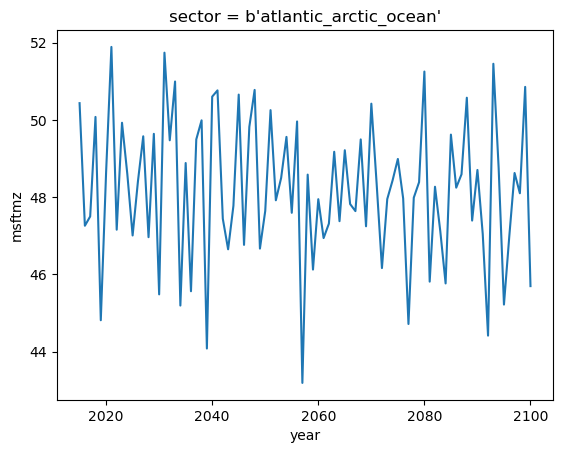

In [64]:
AMOC_Strength["FGOALS-g3"].plot()

## Rolling Mean for smoothing

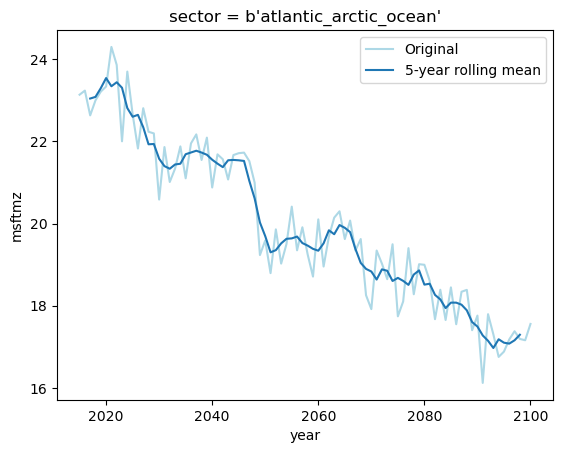

In [67]:
smoothed = AMOC_Strength["ACCESS-CM2"].rolling(year=5, center=True).mean()

plt.figure()
AMOC_Strength["ACCESS-CM2"].plot(label="Original", color='lightblue')
smoothed.plot(label="5-year rolling mean")
plt.legend()
plt.show()

# Plotting Accross Models

## AMOC Strength

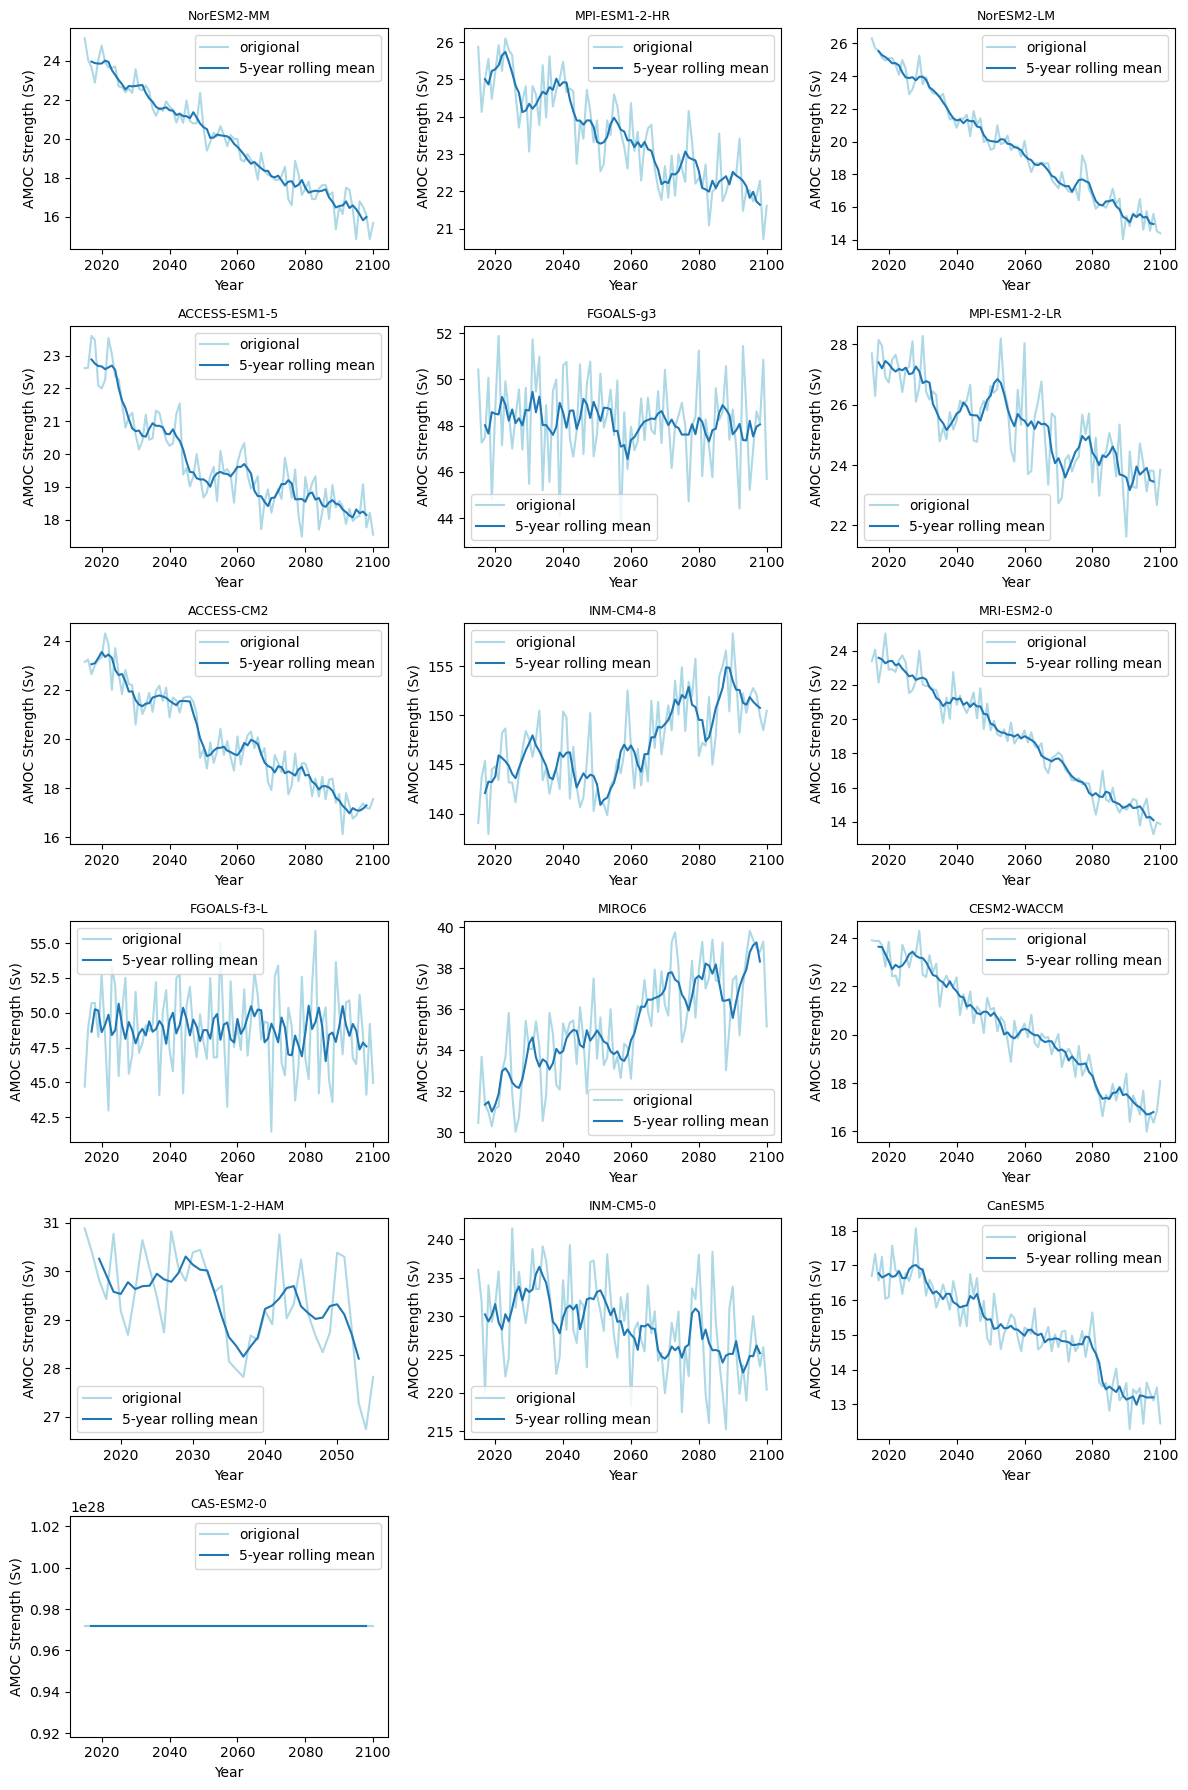

In [68]:
models = list(AMOC_Strength.items())
n = len(models)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols,
    figsize=(4*ncols, 3*nrows),
    sharex=False, 
    sharey=False    
)
axes = axes.flatten()

for ax, (model_name, model) in zip(axes, models):
    # taking monthly max and then averaging over the year
    yearly = model
    smoothed = yearly.rolling(year=5, center=True).mean()

    title = model_name
    ax.plot(yearly["year"], yearly, label="origional", color='lightblue')
    ax.plot(yearly["year"], smoothed, label="5-year rolling mean")
    ax.legend()
    ax.set_title(title, fontsize=9)
    ax.set_xlabel("Year")
    ax.set_ylabel("AMOC Strength (Sv)")

for ax in axes[n:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

## Normalized AMOC Strength

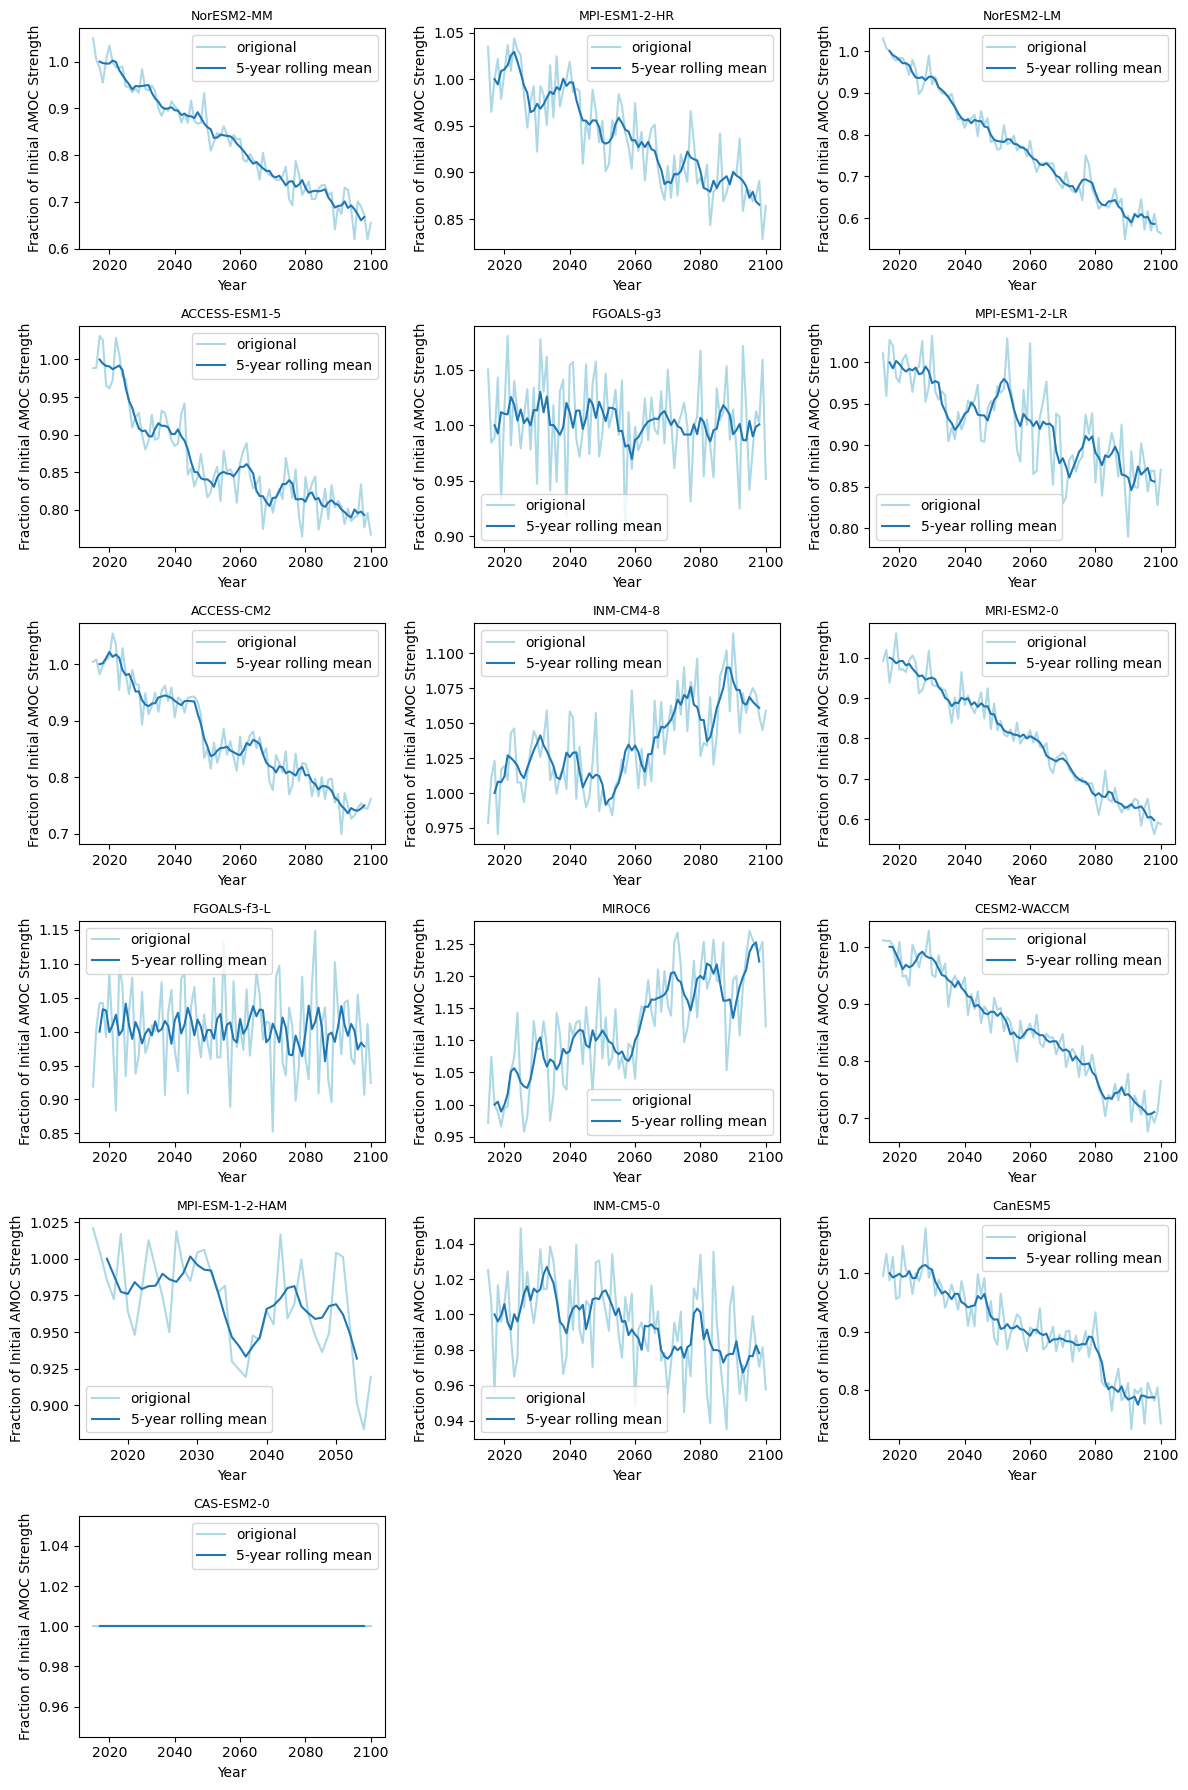

In [69]:
models = list(AMOC_Strength_norm.items())
n = len(models)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols,
    figsize=(4*ncols, 3*nrows),
    sharex=False, 
    sharey=False    
)
axes = axes.flatten()

for ax, (model_name, model) in zip(axes, models):
    # taking monthly max and then averaging over the year
    yearly = model
    # Smoothing using rolling mean
    smoothed = yearly.rolling(year=5, center=True).mean()

    title = model_name
    ax.plot(yearly["year"], yearly, label="origional", color='lightblue')
    ax.plot(yearly["year"], smoothed, label="5-year rolling mean")
    ax.legend()
    ax.set_title(title, fontsize=9)
    ax.set_xlabel("Year")
    ax.set_ylabel("Fraction of Initial AMOC Strength")

for ax in axes[n:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

# All in One Plot

## Strength

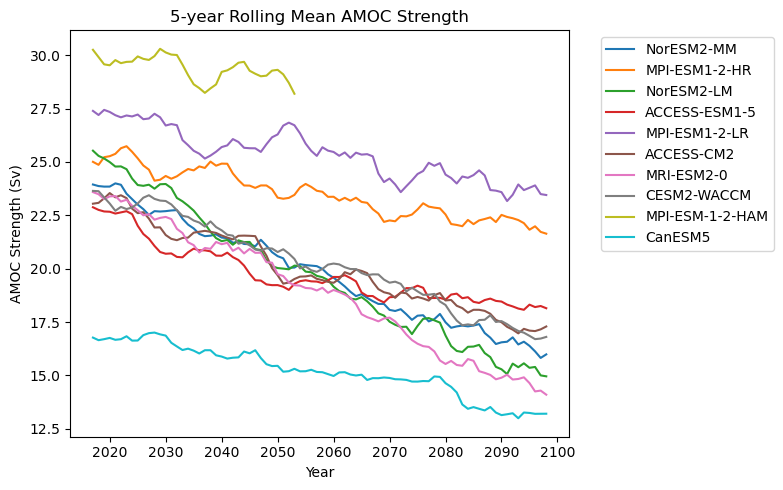

In [ ]:
excluded_models = ["MIROC6", "FGOALS-g3","FGOALS-f3-L", "INM-CM5-0","INM-CM4-8", "CAS-ESM2-0"]
fig, ax = plt.subplots(figsize=(8, 5))

for model_name, model in AMOC_Strength.items():
    if model_name in excluded_models:
        continue
    smoothed = model.rolling(year=5, center=True).mean()
    ax.plot(model["year"], smoothed, label=model_name)

ax.set_title("5-year Rolling Mean AMOC Strength", fontsize=12)
ax.set_xlabel("Year")
ax.set_ylabel("AMOC Strength (Sv)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout()
plt.show()


## Normalized

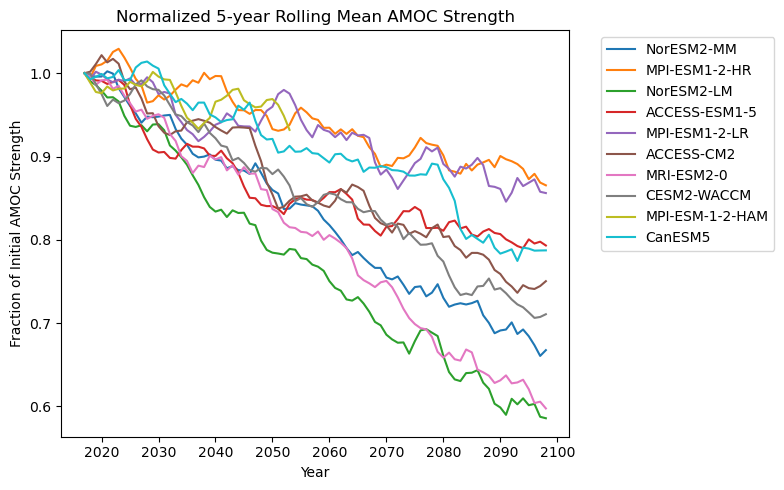

In [ ]:
excluded_models = ["MIROC6", "FGOALS-g3","FGOALS-f3-L", "INM-CM5-0","INM-CM4-8", "CAS-ESM2-0"]
fig, ax = plt.subplots(figsize=(8, 5))

for model_name, model in AMOC_Strength_norm.items():
    if model_name in excluded_models:
        continue
    smoothed = model.rolling(year=5, center=True).mean()
    ax.plot(model["year"], smoothed, label=model_name)

ax.set_title("Normalized 5-year Rolling Mean AMOC Strength", fontsize=12)
ax.set_xlabel("Year")
ax.set_ylabel("Fraction of Initial AMOC Strength")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# CAS-ESM2-0 Abnormals

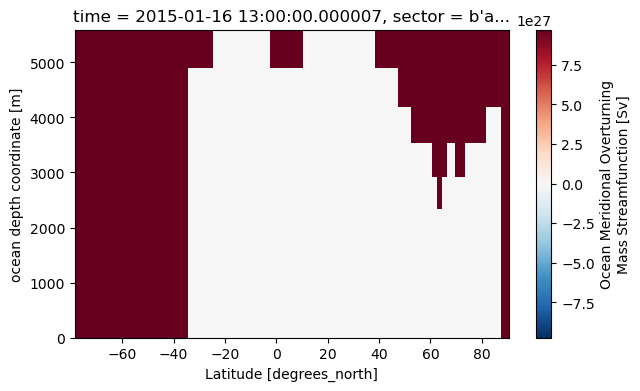

In [ ]:
ds = datasets["CAS-ESM2-0"]
basin_idx = basin_index_map.get("CAS-ESM2-0", 0)
t0 = 0

sec = ds['msftmz'].isel(time=t0, basin=basin_idx)
plt.figure(figsize=(7,4))
p = sec.plot(x='lat', y='lev')
#plt.gca().invert_yaxis() 
plt.show()